In [23]:
!nvidia-smi

Sun Sep  1 17:07:50 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.58.02              Driver Version: 555.58.02      CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          On  |   00000000:C1:00.0 Off |                    0 |
| N/A   27C    P0             69W /  500W |   79701MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

## Librerie importate

In [24]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D
import os
from PIL import Image
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

## Gestione del dataset di immagini

#### Creazione di un dataframe per la gestione e suddivisione del dataset in training set, validation set e test set.

In [25]:
train_folder = 'alfabeto_muto_dataset'
all_data = []
for folder in os.listdir(train_folder):
    if folder == ".DS_Store":
        continue
    label_folder = os.path.join(train_folder, folder)
    onlyfiles = [{'label':folder,'path':os.path.join(label_folder, f)} for f in os.listdir(label_folder) if os.path.isfile(os.path.join(label_folder, f))]
    all_data += onlyfiles
data_df = pd.DataFrame(all_data)

In [26]:
x_train,x_test = train_test_split(data_df, test_size= 0.10, random_state=42,stratify=data_df[['label']])
x_train,x_val = train_test_split(x_train, test_size= 0.25, random_state=42,stratify=x_train[['label']])

In [31]:
img_width, img_height = 64, 64
batch_size = 128
y_col = 'label'
x_col = 'path'
no_of_classes = len(data_df[y_col].unique())


# Creare un ImageDataGenerator per normalizzare le immagini
datagen_train = ImageDataGenerator(
    rescale=1.0/255.0, 
    #rotation_range=20,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #shear_range=0.2,
    #zoom_range=0.2,
    #horizontal_flip=True,
    #fill_mode='nearest',
    #validation_split=0.2
)

# Generare i dati di training 
train_generator = datagen_train.flow_from_dataframe(
    dataframe=x_train,
    x_col=x_col,
    y_col=y_col,
    target_size=(img_width, img_height),
    class_mode='categorical', 
    batch_size=batch_size,
    shuffle=False,
)

# Creare il validation set
val_datagen = ImageDataGenerator(rescale=1.0/255.0)
val_generator = val_datagen.flow_from_dataframe(
    dataframe=x_val, 
    x_col=x_col, 
    y_col=y_col,
    target_size=(img_width, img_height), 
    class_mode='categorical', 
    batch_size=batch_size,
    shuffle=False
)

# Creare il test set
test_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=x_test, 
    x_col=x_col,
    y_col=y_col,
    target_size=(img_width, img_height),
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

Found 58725 validated image filenames belonging to 29 classes.
Found 19575 validated image filenames belonging to 29 classes.
Found 8700 validated image filenames belonging to 29 classes.


### Controllo sul bilanciamento del dataset

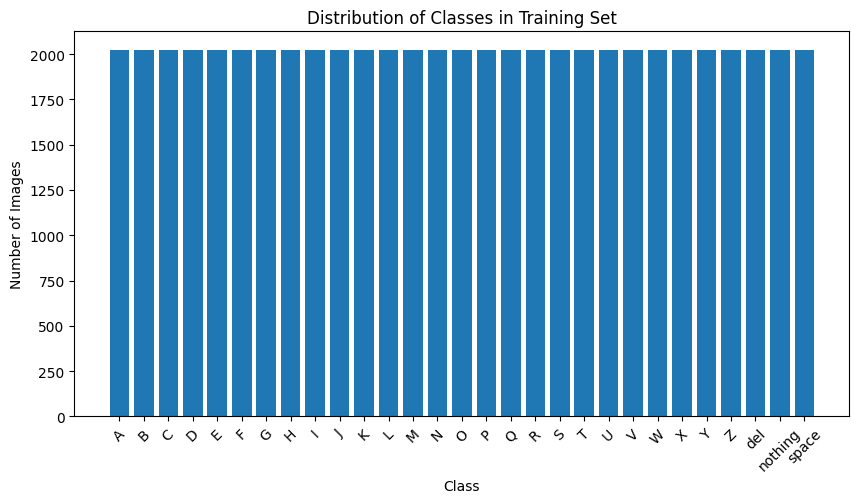

In [32]:

# Etichette delle classi dal generatore del training set
class_labels = train_generator.classes

class_counts = Counter(class_labels)

# Nomi delle classi
class_names = list(train_generator.class_indices.keys())

# Visualizza la distribuzione delle classi: utile per capire se il dataset è sbilanciato per qualche classe
plt.figure(figsize=(10, 5))
plt.bar(class_names, [class_counts[k] for k in range(len(class_names))])
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Distribution of Classes in Training Set')
plt.xticks(rotation=45)
plt.show()

## Training del modello:

Utilizzo dei 3 oggetti utili durante il training: 
- EarlyStopping: serve a stoppare il training dopo x esecuzione senza miglioramento
- ModelCheckpoint: serve a salvare solo il peso migliore ottenuto durante il training per quel modello
- Tensorboard: dashboard utile per monitorare il training (da qui è possibile vedere l'andamento del modello, se per esempio procede verso l'overfitting)

In [33]:
base_model = ResNet50(weights='imagenet', include_top=False)

base_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, None,      │          0 │ input_layer_9[0]… │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, None,      │      9,472 │ conv1_pad[0][0]   │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, None,      │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, None,      │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, None,      │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, None,      │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, None,      │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, None,      │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, None,      │          0 │ conv2_block1_1_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, None,      │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, None,      │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, None,      │          0 │ conv2_block1_2_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, None,      │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, None,      │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, None,      │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, None,      │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

### ResNet50 con finetuning

In [34]:
num_classes = 29  # Numero di classi aggiornato a 29

# Carica il modello pre-addestrato ResNet50, escludendo l'output layer originale)
base_model = ResNet50(weights='imagenet', include_top=False)

# Possibilità di congelare i layer del modello originale: [introduce overfitting e scarse prestazioni (se si utilizza layer.trainable = False)]
#for layer in base_model.layers:
#    layer.trainable = False
for layer in base_model.layers:
    layer.trainable = True

# nuovi layer
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Pooling globale dopo le convoluzioni
x = Dense(1024, activation='relu')(x)  # Layer denso aggiuntivo per migliorare l'apprendimento
x = Dense(256, activation='relu')(x)  # Layer denso aggiuntivo per migliorare l'apprendimento
x = Dense(128, activation='relu')(x)  # Layer denso aggiuntivo per migliorare l'apprendimento
predictions = Dense(num_classes, activation='softmax')(x)  # Layer di output con 29 classi

# Costruzione del modello finale
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# callback per TensorBoard
log_dir = "logs/fit/alphabet_mute_resnet50"
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# callback per ModelCheckpoint per salvare solo i migliori pesi
checkpoint_dir = "checkpoints_model/alphabet_mute_resnet50"
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, 'best_model.keras'),  # Salva il modello nel file best_model.h5
    save_best_only=True,  # Salva solo se il modello migliora
    monitor='val_loss',  # Monitora la perdita sulla validation
    mode='min',  # Miglioramento se la perdita diminuisce
    save_weights_only=False,  # Salva l'intero modello, non solo i pesi
    verbose=1  # Stampa informazioni sul salvataggio
)

early_stop = EarlyStopping(monitor='val_loss',patience=10)


# Training
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[tensorboard_callback, checkpoint_callback, early_stop]
)

# Valutazione sul test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


458/459 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.7928 - loss: 0.7382
Epoch 1: val_loss improved from inf to 29.54283, saving model to checkpoints_model/alphabet_mute_resnet50/best_model.keras
459/459 ━━━━━━━━━━━━━━━━━━━━ 90s 120ms/step - accuracy: 0.7933 - loss: 0.7364 - val_accuracy: 0.0345 - val_loss: 29.5428
Epoch 2/50
458/459 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9860 - loss: 0.0517
Epoch 2: val_loss improved from 29.54283 to 4.56544, saving model to checkpoints_model/alphabet_mute_resnet50/best_model.keras
459/459 ━━━━━━━━━━━━━━━━━━━━ 38s 82ms/step - accuracy: 0.9860 - loss: 0.0517 - val_accuracy: 0.5632 - val_loss: 4.5654
Epoch 3/50
459/459 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9867 - loss: 0.0502
Epoch 3: val_loss improved from 4.56544 to 0.94678, saving model to checkpoints_model/alphabet_mute_resnet50/best_model.keras
459/459 ━━━━━━━━━━━━━━━━━━━━ 39s 84ms/step - accuracy: 0.9867 - loss: 0.0502 - val_accuracy: 0.7954 - val_loss: 0.9468
Epoch 4/50
458/

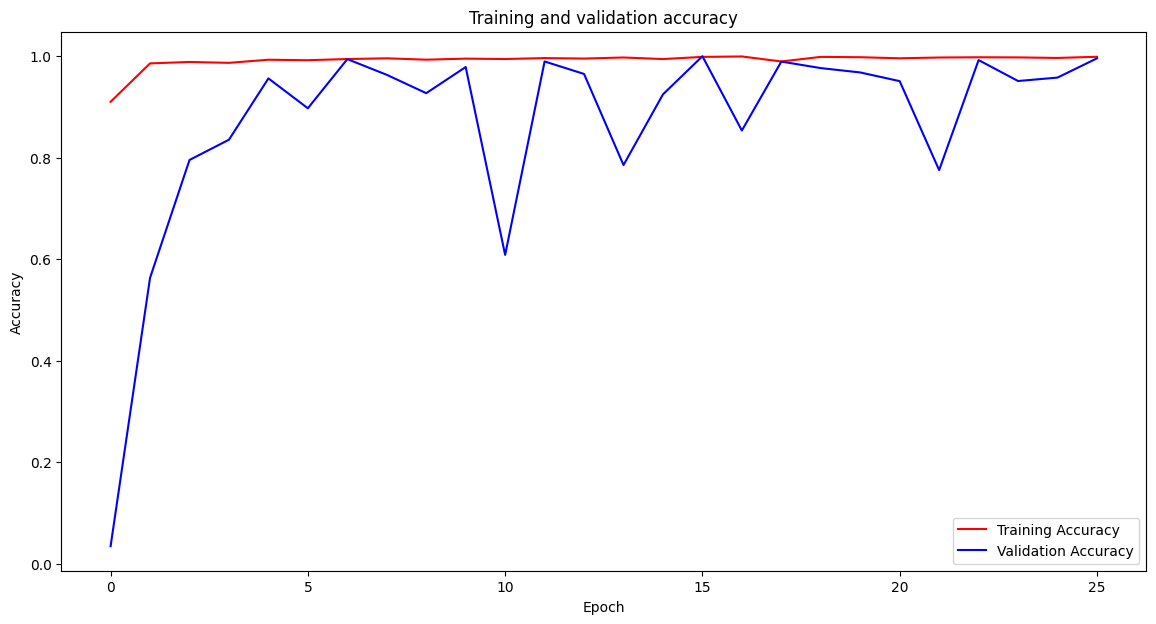

In [35]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc))

fig = plt.figure(figsize=(14,7))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.show()

Text(0.5, 1.0, 'Training and validation loss')

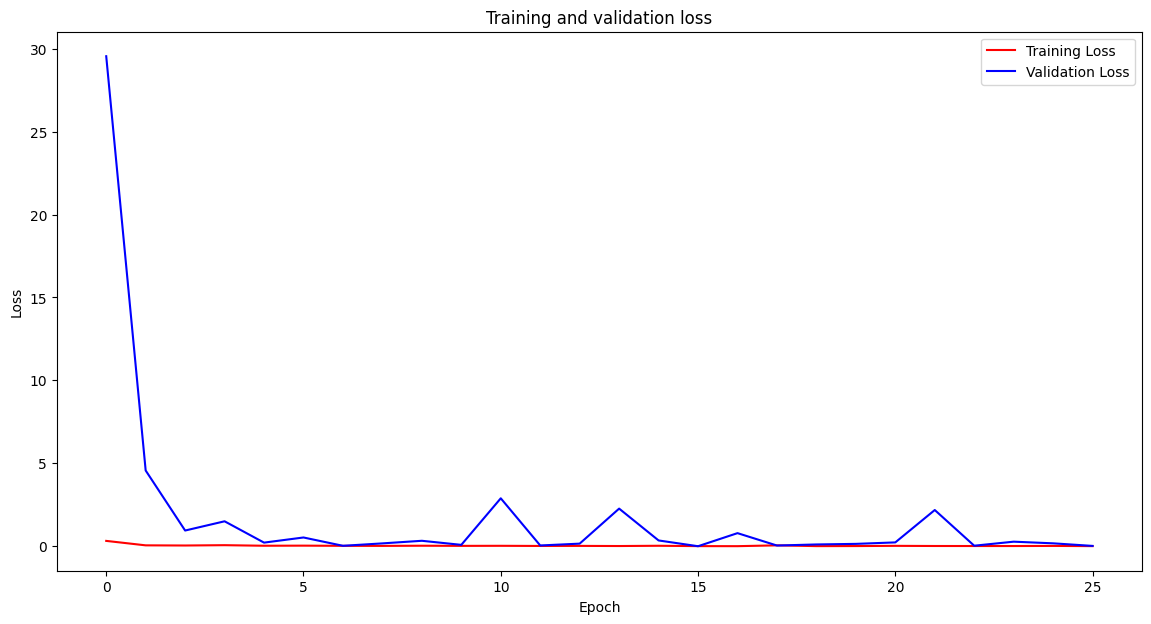

In [36]:
fig = plt.figure(figsize=(14,7))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')

In [39]:
%load_ext tensorboard
%tensorboard --logdir logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6007 (pid 37261), started 0:04:25 ago. (Use '!kill 37261' to kill it.)